In [5]:
import copy
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

## Neural Program Induction: Conway's Game of Life

Conway's Game consists of checking the neighbors and updating the life phase. The experiments gradually evolve by adding more constraints on update_life.

In [27]:
def check_neighbours(life, x_coord, y_coord):
    max_x, max_y = len(life), len(life[0])
    c = 0
    for x,y in [(x_coord+i,y_coord+j) for i in (-1,0,1) for j in (-1,0,1) if i != 0 or j != 0]:
        if 0 <= x < max_x and 0 <= y < max_y:
            if life[x][y]:
                c += 1
    return c

In [54]:
def update_life(life, n):
    new_life = copy.deepcopy(life)
    for r, row in enumerate(life):
        for c, val in enumerate(row):
            n_neig = check_neighbours(life, r, c)
            # This part changes at each experiment. 
            # First experiment: predict n. 
            if n_neig < n :
                new_life[r][c] = 0
    return new_life

In [56]:
# The checkerboard that we will use for our experiments.

life = [[0, 0, 1, 1, 0, 0, 1, 1],
        [1, 0, 0, 1, 0, 0, 1, 1],
        [1, 1, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 1, 1, 0, 1, 1]]
print("Before: \n", np.matrix(life))

Before: 
 [[0 0 1 1 0 0 1 1]
 [1 0 0 1 0 0 1 1]
 [1 1 0 0 1 0 0 0]
 [1 0 0 1 1 0 1 1]]


In [55]:
n = 3 # number of neighbors
for i in range(5):
    new_life = update_life(life, n)
    print("Phase: ", i+1 ," \n", np.matrix(new_life))

Phase:  1  
 [[0 0 0 0 0 0 1 1]
 [0 0 0 1 0 0 1 1]
 [1 1 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0]]
Phase:  2  
 [[0 0 0 0 0 0 1 1]
 [0 0 0 1 0 0 1 1]
 [1 1 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0]]
Phase:  3  
 [[0 0 0 0 0 0 1 1]
 [0 0 0 1 0 0 1 1]
 [1 1 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0]]
Phase:  4  
 [[0 0 0 0 0 0 1 1]
 [0 0 0 1 0 0 1 1]
 [1 1 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0]]
Phase:  5  
 [[0 0 0 0 0 0 1 1]
 [0 0 0 1 0 0 1 1]
 [1 1 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0]]


### Train with a single in/out pair

First we train the feed forward neural network with the same pair of in-out phases. We can easily learn n after few steps.

In [22]:
N, M = len(life), len(life[0])

# Flatten the grids into vectors and concatenate. 
life_in = torch.FloatTensor(life).view(1, N*M)
new_life_in = torch.FloatTensor(new_life).view(1, N*M)
life_input = torch.cat((life_in, new_life_in), 1)

#print(life_in.view(1, 12))
print(life_input.shape)

input_dim = N*M*2
output_dim = 9

fc = nn.Linear(input_dim, output_dim)
criterion = nn.CrossEntropyLoss()
target = torch.LongTensor([n])
print("target: ", target)

optim = torch.optim.SGD(fc.parameters(), lr=1e-3)

losses = []

for t in range(1000):
    out = fc(life_input)

    loss = criterion(out, target)

    _, predicted = torch.max(out, 1)
    if predicted == n:
            print("STOP! Phase: ", t)
            break
    
    if t%200 == 0:
        print("Loss: ", loss)
        _, predicted = torch.max(out, 1)
        
    losses.append(loss)

    optim.zero_grad()
    loss.backward()
    optim.step()

torch.Size([1, 64])
target:  tensor([3])
Loss:  tensor(2.3069, grad_fn=<NllLossBackward>)
STOP! Phase:  13


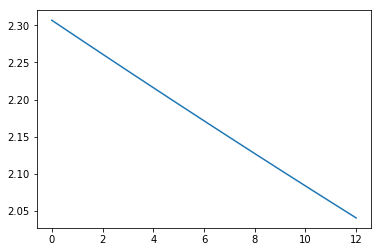

In [23]:
plt.plot(losses)

### Train with a life 

Now at each gradient descent step, introduce the pair of new phases updated by the rules.

In [24]:
fc = nn.Linear(input_dim, output_dim)
criterion = nn.CrossEntropyLoss()
target = torch.LongTensor([n])

optim = torch.optim.SGD(fc.parameters(), lr=1e-3)

losses = []

for t in range(201):
    
    # update life
    new_life = update_life(life, n)
    life_in = torch.FloatTensor(life).view(1, N*M)
    new_life_in = torch.FloatTensor(new_life).view(1, N*M)
    life_input = torch.cat((life_in, new_life_in), 1)
    
    out = fc(life_input)
    loss = criterion(out, target)

    _, predicted = torch.max(out, 1)
    if predicted == n:
            print("STOP! ", t)
            break
    
    if t%200 == 0:
        print(loss)
        print(predicted)
        
        
    losses.append(loss)

    optim.zero_grad()
    loss.backward()
    optim.step()
    
    life = copy.deepcopy(life)

tensor(2.1066, grad_fn=<NllLossBackward>)
tensor([7])
STOP!  18


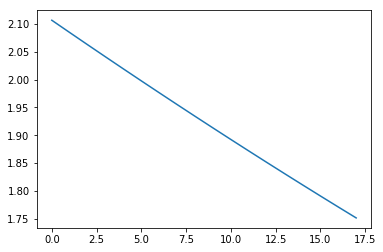

In [25]:
plt.plot(losses)

# Second Experiment

Introduce two variables in update rule to be predicted.

In [57]:
def update_life(life, m, n):
    new_life = copy.deepcopy(life)
    for r, row in enumerate(life):
        for c, val in enumerate(row):
            n_neig = check_neighbours(life, r, c)
            # This part changes at each experiment. 
            if n_neig != m and n_neig != n:
                new_life[r][c] = 0
                
    return new_life

In [58]:
m = 2 
n = 3

In [68]:
target = torch.zeros((1,9))
target[0,m]=1
target[0,n]=1
target

tensor([[0., 0., 1., 1., 0., 0., 0., 0., 0.]])

In [95]:
fc = nn.Linear(input_dim, output_dim)
criterion = nn.BCEWithLogitsLoss()
target = torch.zeros((1,9))
target[0,m]=1
target[0,n]=1

optim = torch.optim.SGD(fc.parameters(), lr=1e-3)

losses = []

for t in range(100):
    
    # update life
    new_life = update_life(life, m, n)
    life_in = torch.FloatTensor(life).view(1, N*M)
    new_life_in = torch.FloatTensor(new_life).view(1, N*M)
    life_input = torch.cat((life_in, new_life_in), 1)
    
    out = fc(life_input)
    #print(out)
    loss = criterion(out, target)

    pred = torch.zeros_like(target)
    ind = torch.topk(out, 2)[1][0]
    pred[0, ind[0]]=1
    pred[0, ind[1]]=1
    if torch.all(torch.eq(pred, target)):
        print("STOP! ", t)
        break
        
    if t%50 == 0:
        print("loss: ", loss)
        print("pred: ", ind)
        
    losses.append(loss)

    optim.zero_grad()
    loss.backward()
    optim.step()
    
    life = copy.deepcopy(life)

loss:  tensor(0.6417, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
pred:  tensor([2, 1])
loss:  tensor(0.6046, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
pred:  tensor([2, 1])
STOP!  52


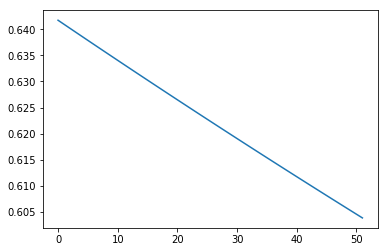

In [96]:
plt.plot(losses)